In [1]:
import torch
import h5py 
from Bio import SeqIO

fasta_file = "../data/seqs/cmap_prots.fasta"
ffile = list(SeqIO.parse(fasta_file, "fasta"))
plt400 = {p.id  for p in ffile if len(p.seq) < 400}
len(plt400), len(ffile)

(27762, 31145)

In [6]:
import numpy as np
"""
h5loc_out = "../data/embeddings/cmap_filtered_lt_400.h5"
h5loc_in = "../data/embeddings/cmap_outs.h5"

with h5py.File(h5loc_in, "r") as fr, h5py.File(h5loc_out, "w") as fw:
    allkeys = list(fr.keys())
    pkeys = [k.split("x") for k in allkeys]
    pkeysf = [f"{p}x{q}" for p, q in pkeys if p in plt400 and q in plt400]
    
    print(f"Length to write: {len(pkeysf)}, Original size: {len(pkeys)}")
    for key in pkeysf:
        mat = fr.get(key)[()]
        mat = 1 - (mat / np.max(mat))
        fw.create_dataset(key,
                          data = mat,
                          compression="lzf",
                          dtype = "float32")
"""

Length to write: 24483, Original size: 28685


In [7]:
from random import choices
h5locs = [h5loc_out]

def draw_samples(A, n, dtype=torch.FloatTensor):
    xg, yg = np.meshgrid(
        np.linspace(0, 1, A.shape[1]),
        np.linspace(0, 1, A.shape[0]),
        indexing="xy",
    )
    grid = list(zip(xg.ravel(), yg.ravel()))
    dens = A.ravel() 
    dots = np.array(choices(grid, dens, k=n))
    dots += (0.5 / A.shape[0]) * np.random.standard_normal(dots.shape)
    return torch.from_numpy(dots).type(dtype)



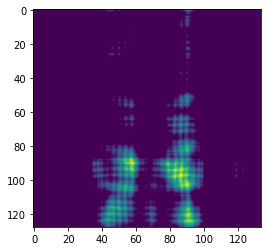

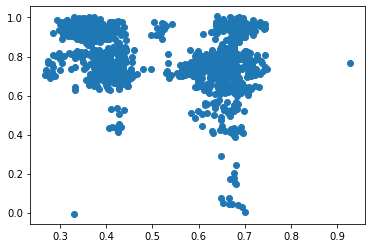

In [9]:
h5file = h5py.File(h5loc_out, "r")
import matplotlib.pyplot as plt
keys = list(h5file.keys())
plt.figure()
img = h5file.get(keys[6])[()]
plt.imshow(img)

X = draw_samples(img, 1000)
plt.figure()
plt.scatter(X[:, 0], X[:, 1])

In [24]:
from torch.utils.data import DataLoader, Dataset, random_split
from glob import glob
import skimage.measure as skmeas #!conda install scikit-image --yes
from random import choices

preprocess = lambda a: skmeas.block_reduce(a[0], (a[1],a[1]), np.max)


class CmapData(Dataset):
    def __init__(self, h5locs, no_samples = 100, max_row = 500, max_col = 500, threshold = 0.1, preprocess = None):
        super(CmapData, self).__init__()
        print(h5locs)
        self.h5files = [h5py.File(h5loc, "r") for h5loc in h5locs]
        self.no_samples = no_samples
        self.max_row = max_row
        self.max_col = max_col
        self.preprocess = preprocess
        
        self.counts = [0]
        self.h5samples = []
        for f in self.h5files:
            self.h5samples += list(f.keys())
            self.counts.append(len(self.h5samples))
        print(self.counts)
        
        self.threshold = threshold
    
    def get_loc(self, id):
        h5id = 0
        for i in self.counts[1:]:
            if id >= i:
                h5id += 1
            else:
                return self.h5files[h5id]
                
    def __len__(self):
        return 1000 # len(self.h5samples)
    
    def __getitem__(self, id):
        assert id < len(self.h5samples)
        
        key = self.h5samples[id]
        h5sample = self.get_loc(id)
        A = h5sample.get(key)[()]
        
        if self.preprocess is not None:
            A = self.preprocess(A)
        m, n = A.shape
        
        pad_y = self.max_row - m
        pad_x = self.max_col - n
        
        A = np.pad(A, ((0, pad_y), (0, pad_x)))

        X = draw_samples(A, self.no_samples, dtype = torch.float32)
        A = torch.tensor(A, dtype = torch.float32).unsqueeze(0)
        return A, X
    

allset = CmapData(h5locs, 100, preprocess = None)
n = len(allset)
trainset, testset = random_split(allset, [int(0.9 * n) , n - int(0.9 * n)])
trainloader = DataLoader(trainset, batch_size=1, shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=True)
len(testset)

['../data/embeddings/cmap_filtered_lt_400.h5']
[0, 24483]


100

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class SamplingModel(nn.Module): 
    def __init__(self, sample_size = 100):
        super(SamplingModel, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 5, kernel_size = 2, stride = 2), # N, 1, H, W => N, 5, H', W'
            nn.Tanh(),
            nn.MaxPool2d(3),
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels = 5, out_channels = 2, kernel_size = 7, stride = 2), # N, 5, H'', W'' => N, 2, H''', W'''
            nn.MaxPool2d(2),
            nn.Tanh(),
            nn.Flatten(start_dim = 2),
            nn.LazyLinear(sample_size),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)
    
device = torch.device(1)

In [26]:
device

device(type='cuda', index=1)

In [28]:
from geomloss import SamplesLoss

model = SamplingModel().to(device)

model.train()
output_dir = "sampler-sav"
k=0

lossf = SamplesLoss("sinkhorn", p=2, blur=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for i in range(10):
    running_loss = 0
    for e, data in enumerate(trainloader):
        A, Y = data
        A = A.to(device)
        Y = Y.to(device)
        
        optimizer.zero_grad()
        Y_pred = torch.transpose(model(A), 1, 2).squeeze(0).squeeze(0)
        loss = lossf(Y.squeeze(0), Y_pred)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if device.type != "cpu":
            A = A.to("cpu")
            Y = Y.to("cpu")
            loss = loss.to("cpu")
            Y_pred = Y_pred.to("cpu")
        
    running_loss /= (e+1)
    print(f"Running Iteration {i+k+1}, Loss: {running_loss}")
    torch.save(model, f"{output_dir}/iter_{i+k}.sav")

Running Iteration 1, Loss: 0.012900968560586788
Running Iteration 2, Loss: 0.012311856394646586
Running Iteration 3, Loss: 0.011285307144280523
Running Iteration 4, Loss: 0.011062748329487577
Running Iteration 5, Loss: 0.008921940455361942
Running Iteration 6, Loss: 0.008145731317959468
Running Iteration 7, Loss: 0.008301232844872478
Running Iteration 8, Loss: 0.008053541789478105
Running Iteration 9, Loss: 0.007898692719075673
Running Iteration 10, Loss: 0.007845838850464335


In [4]:
#torch.save(model, "/sampler-sav/iter_995.sav")
model = torch.load("sampler-sav/iter_9.sav", map_location=device)

100
100


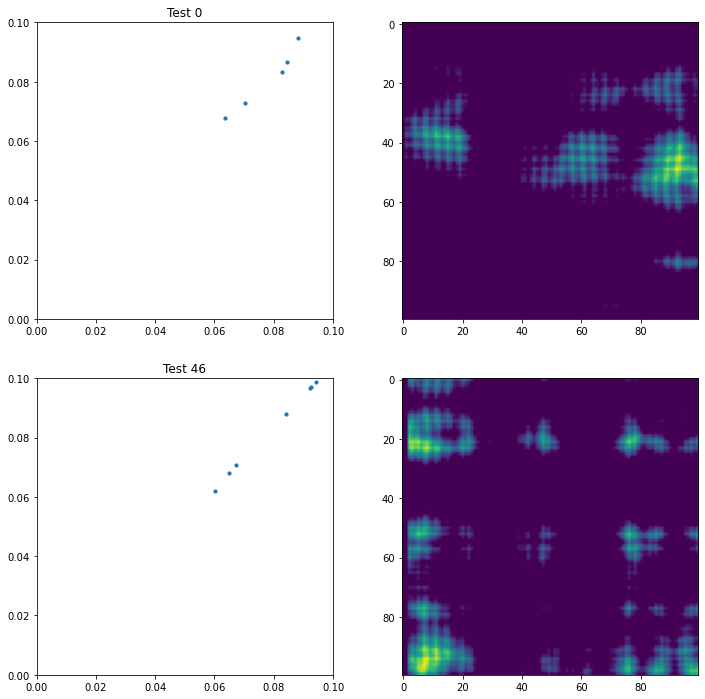

In [11]:
def display_samples(ax, x, color):
    x_ = x.detach().cpu().numpy()
    ax.scatter(x_[:, 0], x_[:, 1], color, edgecolors="none")
    
testex = np.random.randint(len(testset), size = 2)
model.eval()

fig, axes = plt.subplots(nrows = len(testex), ncols = 2, figsize = (12, 12))

with torch.no_grad():
    for i, k in enumerate(testex):
        A, Y = testset[k]
        
        A  = A.to(device)
        Y  = Y.to(device)
        
        Ypred = torch.transpose(model(A.unsqueeze(0)), 1, 2).squeeze(0).squeeze(0)
        if device.type != "cpu":
            Ypred = Ypred.to("cpu")
            A = A.to("cpu")
            Y = Y.to("cpu")
        
        colors = (20 * Ypred[:, 0]).cos() * (20 * Ypred[:, 1]).cos()
        colors = colors.numpy()
        colors = np.concatenate([colors, 
                                 #[0] * colors.shape[0]
                                ])
        # display_samples(axes[i, 0], torch.concat([#Ypred, 
        #                                   Y
        #                                  ]), color= [0] * colors.shape[0])
        print(len(Y))
        axes[i, 0].scatter(Ypred[:, 0], Ypred[:, 1], s = 10)
        axes[i, 0].set_title(f"Test {k}")
        axes[i, 0].set_aspect("equal", adjustable="box")
       
        axes[i, 0].axis([0, 0.1, 0, 0.1])
        
#         plt.xticks([], [])
#         plt.yticks([], [])
        axes[i, 1].imshow(A[0][np.arange(99, -1, -1), : 100])
        
        plt.gca().set_aspect("equal", adjustable="box")
        
#plt.tight_layout()
plt.show()

In [17]:
import re
comp = re.compile(r"_(\d*).sav")
comp.search("iter_20.sav").group(1)

'20'

In [29]:
ofile = open("file.txt", "w")
ofile.write("abc")

3

In [30]:
ofile.flush()

In [32]:
ofile.close()

In [3]:
!cd ..; python setup.py build; python setup.py install

running build
running build_py
copying dscript/commands/train_sampler.py -> build/lib/dscript/commands
running egg_info
writing manifest file 'dscript.egg-info/SOURCES.txt'
running install
/scratch2/kdevko01/conda/.conda/envs/dscript/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,
/scratch2/kdevko01/conda/.conda/envs/dscript/lib/python3.7/site-packages/setuptools/command/easy_install.py:159: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  EasyInstallDeprecationWarning,
running bdist_egg
running egg_info
writing manifest file 'dscript.egg-info/SOURCES.txt'
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/dscript
creating build/bdist.linux-x86_64/egg/dscript/commands
creating build/bdist

In [24]:
!dscript sampler  --embedding ../data/embeddings/cmap_filtered_lt_400.h5 --output ../data/models/sampler --device 1 

/scratch2/kdevko01/conda/.conda/envs/dscript/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Running Interation 2, Loss: 0.020970997339463792
Running Interation 3, Loss: 0.020067682609835175
Running Interation 4, Loss: 0.019953043335932306
Running Interation 5, Loss: 0.01988006363005843
Running Interation 6, Loss: 0.020015784200280905
Running Interation 7, Loss: 0.019908647779142485
Running Interation 8, Loss: 0.01995570967788808
Running Interation 9, Loss: 0.019881031747441737
Running Interation 10, Loss: 0.020065978338068818


In [19]:
import h5py

f = h5py.File("../data/embeddings/cmap_filtered_lt_400.h5", "r")

In [118]:
!dscript train --train ../data/pairs/human_train_200.tsv --test ../data/pairs/human_test_40.tsv \
--embedding ../bash_files/embeddings/human.h5 --run-cmap \
--contact-map-train ../data/pairs/cmap_debug_train.tsv --contact-map-test ../data/pairs/cmap_debug_test.tsv \
--contact-map-mode ot --contact-map-embedding ../lynnfiles/new_cmap_embed --contact-maps ../data/embeddings/cmap_debug.h5 \
--contact-map-sampler ../data/models/sampler/iter_9.sav --save-prefix results_  --device 1 \
--ot-cmap-nsamples 100

[2022-12-26-04:56:02] D-SCRIPT Version 0.2.2
[2022-12-26-04:56:02] D-SCRIPT Version 0.2.2
[2022-12-26-04:56:02] Called as: /scratch2/kdevko01/conda/.conda/envs/dscript/bin/dscript train --train ../data/pairs/human_train_200.tsv --test ../data/pairs/human_test_40.tsv --embedding ../bash_files/embeddings/human.h5 --run-cmap --contact-map-train ../data/pairs/cmap_debug_train.tsv --contact-map-test ../data/pairs/cmap_debug_test.tsv --contact-map-mode ot --contact-map-embedding ../lynnfiles/new_cmap_embed --contact-maps ../data/embeddings/cmap_debug.h5 --contact-map-sampler ../data/models/sampler/iter_9.sav --save-prefix results_ --device 1 --ot-cmap-nsamples 100
[2022-12-26-04:56:02] Called as: /scratch2/kdevko01/conda/.conda/envs/dscript/bin/dscript train --train ../data/pairs/human_train_200.tsv --test ../data/pairs/human_test_40.tsv --embedding ../bash_files/embeddings/human.h5 --run-cmap --contact-map-train ../data/pairs/cmap_debug_train.tsv --contact-map-test ../data/pairs/cmap_debug_

In [32]:
import pandas as pd
df = pd.read_csv("../data/pairs/cmap_test_lt_400.tsv", sep = "\t", header = None)
cmap = h5py.File("../data/embeddings/cmap_filtered_lt_400.h5", "r")
cmapkeys = set(list(cmap.keys()))

In [45]:
dkeys = df.apply(lambda x : f"{x[0]}x{x[1]}", axis = 1).values

In [55]:
cmap_h5fi = h5py.File("../lynnfiles/new_cmap_embed", "r")
cmaph5keys = list(cmap_h5fi.keys())
cmap_h5fi.close()

In [58]:
df = pd.read_csv("../data/pairs/human_train.tsv", sep = "\t", header = None)
df.sample(100)

,0,1,2
420882,9606.ENSP00000297873,9606.ENSP00000225899,0
223374,9606.ENSP00000308622,9606.ENSP00000485383,0
201945,9606.ENSP00000367851,9606.ENSP00000376423,0
148840,9606.ENSP00000262430,9606.ENSP00000290868,0
232700,9606.ENSP00000356467,9606.ENSP00000263610,0
...,...,...,...
374784,9606.ENSP00000321266,9606.ENSP00000379126,0
233390,9606.ENSP00000246549,9606.ENSP00000354554,0
223408,9606.ENSP00000371920,9606.ENSP00000414070,0
402129,9606.ENSP00000297404,9606.ENSP00000423628,0


In [64]:
import numpy as np
with h5py.File("../data/embeddings/cmap_filtered_lt_400.h5", "r") as hi, h5py.File("../data/embeddings/cmap_debug.h5", "w") as ho:
    hikeys = np.array(list(hi.keys()))
    for key in hikeys[np.random.randint(len(hikeys), size = 100)]:
        ho.create_dataset(key, data = hi.get(key)[:],
                          dtype = "float",
                          compression = "lzf")

In [68]:
with h5py.File("../data/embeddings/cmap_debug.h5", "r") as hi:
    keys = set(list(hi.keys()))

In [115]:
keypair = {tuple(key.split("x")) for key in keys}
df = pd.read_csv("../data/pairs/cmap_train_lt_400.tsv", sep = "\t", header = None)
df = df[df.loc[:, [0, 1]].apply(lambda x : (x[0], x[1]) in keypair, axis = 1)]

In [116]:
df

,0,1,2
268,3QQ9:D,3QQ9:L,1
455,4R7N:K,4R7N:L,1
472,6AZX:A,6AZX:B,1
507,2AK4:J,2AK4:R,1
773,4KXZ:E,4KXZ:N,1
...,...,...,...
21035,2G2U:A,2G2U:B,1
21038,4H3H:A,4H3H:D,1
21245,5NWD:A,5NWD:B,1
21725,6FQA:C,6FQA:D,1


In [117]:
df.to_csv("../data/pairs/cmap_debug_train.tsv", sep = "\t", header = None, index = None)

In [104]:
import torch.nn.functional as F
import torch
x = torch.randn(1, 3, 3)
F.pad(x, (0, 5, 0, 3))

tensor([[[-0.2026,  0.2856, -0.2950,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.6563, -0.2099,  0.4500,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [-1.5026, -0.2073, -0.3909,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000]]])